# Trabalho Final: Deep Learning

**FUNDAÇÃO UNIVERSIDADE REGIONAL DE BLUMENAU**  
**CENTRO DE CIÊNCIAS EXATAS E NATURAIS**  
**DEPARTAMENTO DE SISTEMAS E COMPUTAÇÃO**  
**Professor: Luan Porfirio e Silva**  
**Disciplina: Deep Learning (Pós-graduação em Data Science)**  
**Aluno: Márcio Koch**  

### Classificação de textos para análise de sentimentos

Base de dados 

Istruções:
- O objetivo deste trabalho é criar um modelo binário de aprendizado de máquina para classificação de textos. 
Para isso, será utilizado a base de dados [IMDb](http://ai.stanford.edu/~amaas/data/sentiment/), que consiste de dados textuais de críticas positivas e negativas de filmes
- Uma vez treinado, o modelo deve ter uma função `predict` que recebe uma string como parâmetro e retorna o valor 1 ou 0, aonde 1 significa uma crítica positiva e 0 uma crítica negativa
- O pré-processamento pode ser desenvolvidado conforme desejar (ex.: remoção de stopwords, word embedding, one-hot encoding, char encoding)
- É preferível que seja empregado um modelo de recorrência (ex.: rnn, lstm, gru) para a etapa de classificação
- Documente o código (explique sucintamente o que cada função faz, insira comentários em trechos de código relevantes)
- **Atenção**: Uma vez treinado o modelo final, salve-o no diretório do seu projeto e crie uma célula ao final do notebook contendo uma função de leitura deste arquivo, juntamente com a execução da função `predict`

Sugestões:
- Explorar a base de dados nas células iniciais do notebook para ter um melhor entendimento do problema, distribuição dos dados, etc
- Após desenvolver a estrutura de classificação, é indicado fazer uma busca de hiperparâmetros e comparar os resultados obtidos em diferentes situações

Prazo de entrega:
- 01-08-2021 às 23:59hs GMT-3

Formato preferível de entrega:
- Postar no portal Ava da disciplina o link do projeto no github (ou anexar o projeto diretamente no portal Ava)

luann.porfirio@gmail.com

In this kernel we will go through a sentiment analysis on imdb dataset using LSTM.

In [16]:
# Baseado no original em: https://www.kaggle.com/arunmohan003/sentiment-analysis-using-lstm-pytorch

#Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext import datasets

# Tratamentos das stopwords
import nltk
nltk.download('stopwords')

# Suporte a uso de GPU para processamento, caso não tenha GPU disponível, usa CPU.
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU disponível")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
GPU not available, CPU used


In [17]:
# Carrega o banco de dados, e divide as imagens em treino e teste.
train_iter, test_iter = datasets.IMDB()

aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:05<00:00, 14.8MB/s]


In [18]:
# Coloca as linhas de texto e rótulos cada uma em uma lista.
def read_test_train_dir(data_iter):
    labels = []
    texts = []     
    for label, text in data_iter:
      texts.append(text)
      labels.append(0 if label == 'neg' else 1)
      
    return np.array(texts), np.array(labels)

In [19]:
## Load the each text into texts list
## corresponding label will be in labels list. 
def read_test_train_dir3(data_iter):
    labels = []
    texts = []

    top = 15000
    pos_ = 0
    neg_ = 0
    max = int(top/2)

    count = 0
    print('max:', max)
    for label, text in data_iter:
      count = count + 1
      #if (count > 200):
      #  break

      isPos = label == 'pos' and pos_ <= max
      #print('isPos:', isPos, ', label:', label, ', pos_:', pos_, ', max:', max)

      if isPos:
        texts.append(text)
        labels.append(1)
        pos_ = pos_ + 1

      isNeg = label == 'neg' and neg_ <= max
      #print('isNeg:', isNeg, ', label:', label, ', neg_:', neg_, ', max:', max)
      if isNeg:
        texts.append(text)
        labels.append(0)
        neg_ = neg_ + 1

      if top > 0 and len(texts) == top:
        break
      
    #print('labels:', labels)
    return np.array(texts), np.array(labels)

In [232]:
# Carrega as linhas dos textos e rótulos, tanto para treino como para testes.
x_train,y_train = read_test_train_dir(train_iter)
x_test, y_test = read_test_train_dir(test_iter)

x_train2 = x_train.copy()
y_train2 = y_train.copy()
x_test2 = x_test.copy()
y_test2 = y_test.copy()

In [20]:
x_train,y_train = read_test_train_dir3(train_iter)
x_test, y_test = read_test_train_dir3(test_iter)

x_train2 = x_train.copy()
y_train2 = y_train.copy()
x_test2 = x_test.copy()
y_test2 = y_test.copy()

max: 7500
max: 7500


In [21]:
# Imprimi só pra ver e conferir os rótulos
print(y_test2)

[0 0 0 ... 1 1 1]


In [22]:
# Mostra os tamanhos dos arrays.
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (15000,)
shape of test data is (15000,)


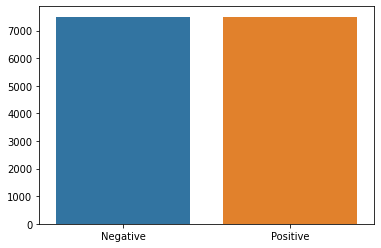

In [23]:
# Plota para ver a simetria das amostras negativas e positivas de treino.
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['Negative','Positive']),y=dd.values)
plt.show()

In [24]:
def preprocess_string(s):    
    # Remova todos os caracteres que não sejam palavras (tudo exceto números e letras)
    s = re.sub(r"[^\w\s]", '', s)

    # Trata espaços em branco
    s = re.sub(r"\s+", '', s)

    # Substitui dígitos sem espeços
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    
    # Classificar com base nas palavras mais comuns
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]

    # Cria um dicionário
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    # Tockenize
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [25]:
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [26]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


### Analysing review length

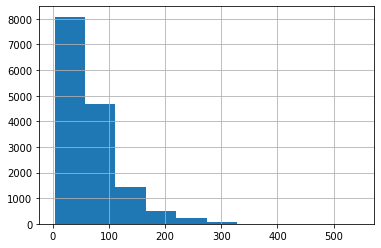

count    15000.000000
mean        69.833800
std         48.848481
min          3.000000
25%         39.000000
50%         55.000000
75%         85.000000
max        545.000000
dtype: float64

In [27]:
# Mostra uma estatística do comprimento das palavras das linhas de texto para treino.
rev_len = [len(i) for i in x_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

### Padding

In [28]:
# Preenche cada uma das sequências até o comprimento máximo.
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [29]:
# Temos um número muito menor de comentários com comprimento > 500.
# Portanto, vamos considerar apenas aqueles abaixo dela.
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)


### Batching and loading as tensor

In [30]:
# Cria o dataset do Tensor.
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

# dataloaders
batch_size = 50

# Embaralha os dados
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [31]:
# Obter um lote de dados de treinamento.
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 833, 749, 936],
        [  0,   0,   0,  ...,  23, 914,   7],
        [  0,   0,   0,  ..., 133, 133, 141],
        ...,
        [  0,   0,   0,  ..., 234,   2,   1],
        [  0,   0,   0,  ..., 535, 847,   2],
        [  0,   0,   0,  ...,   1, 938,  48]])
Sample input: 
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


Precisamos adicionar uma camada de incorporação porque há menos palavras em nosso vocabulário. É extremamente ineficiente para codificar one-hot tantas classes. Portanto, em vez de uma codificação one-hot, podemos ter uma camada de embedding e usar essa camada como uma tabela de pesquisa. Você pode treinar uma camada embedding usando Word2Vec e carregá-la aqui. Mas não há problema em apenas fazer uma nova camada, usando-a apenas para redução de dimensionalidade, e deixar a rede aprender os pesos.

### Preparação do modelo

In [32]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        # embedding e camadas LSTM
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        
        
        # Camada dropout
        self.dropout = nn.Dropout(0.3)
    
        # Camada linear e sigmoid.
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)
        # Embeddings e lstm_out
        embeds = self.embedding(x)  # Shape: B x S x Feature, desde que batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        # Dropout e camada totalmente conectada.
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        # Função sigmoid
        sig_out = self.sig(out)
        
        # Remodelar para ser batch_size primeiro
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # Pega último batch de labels
        
        # Retorna última saída sigmoid e estado da camda hidden
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        ''' Inicializa o hidden state '''
        
        # Cria dois novos tensores como tamanhos n_layers x batch_size x hidden_dim.
        # Inicializado para zero, para o hidden state e cell state da LSTM
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden

              

In [33]:
no_layers = 2
vocab_size = len(vocab) + 1 # 1 a mais pra preenchimento (padding)
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

# Move para GPU, caso tenha
model.to(device)

# Imprimi o estado do modelo
print(model)


SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


### Treinamento

In [76]:
# Função de perda e de otimização
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Função para calcular a precisão
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


In [ ]:

# model_path = '/content/drive/MyDrive/Furb/pos-datascience/aclImdb/state_dict.pt'
# Caminho e arquivo onde deve salvar o modelo treinado
model_path = '/state_dict.pt'
clip = 5
epochs = 5
valid_loss_min = np.Inf

epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

# Treina algumas épocas
for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0

    print('Starting epoch:', epoch)

    print('Before model.train()')
    model.train()
    print('After model.train()')

    # Inicializa o hidden state 
    h = model.init_hidden(batch_size)

    print('Before for inputs, labels in train_loader')
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)

        # Criando novas variáveis ​​para o hidden state, caso contrário, 
        # voltaríamos a propagação por todo o histórico de treinamento.
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        # calculate the loss and perform backprop
        # Calcula a perda e realiza o back propagation
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        
        # Calculo da precisão
        accuracy = acc(output,labels)
        train_acc += accuracy
        #`clip_grad_norm` ajuda a prevenir o problema de gradiente explosivo em RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    print('After for inputs, labels in train_loader')
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()

    print('Before for inputs, labels in valid_loader')
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    print('After for inputs, labels in valid_loader')

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)

    # Alguns prints de acompanhamento da perda/precisão por época.
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    #if epoch_val_loss <= valid_loss_min:
    #    torch.save(model.state_dict(), '/content/drive/MyDrive/Furb/pos-datascience/aclImdb/state_dict.pt')
    #    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
    #    valid_loss_min = epoch_val_loss
    print(25*'==')

# Salva o modelo treinado.
torch.save(model.state_dict(), model_path)

Starting epoch: 0
Before model.train()
After model.train()
Before for inputs, labels in train_loader


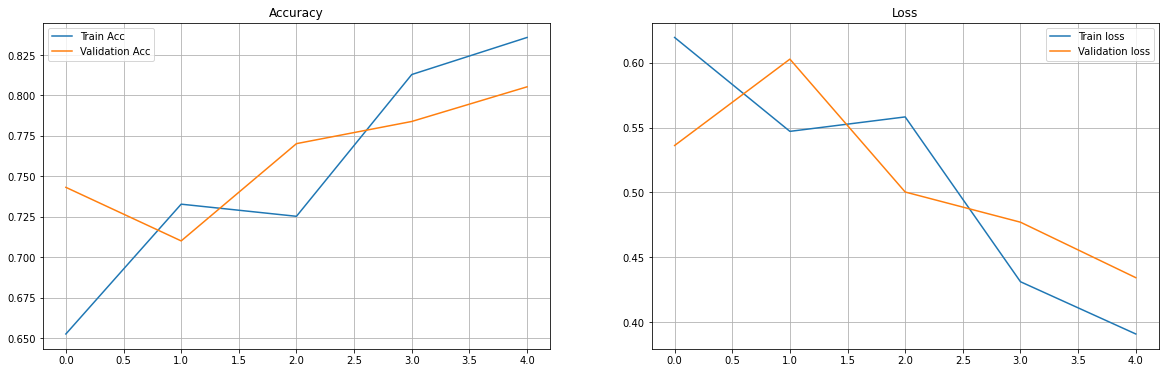

In [50]:
# Plota um gráfico de Precisão x Perda
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

### Carregar o modelo treinado para predição

In [35]:
no_layers = 2
#vocab_size = len(vocab) + 1 # 1 a mais pra preenchimento (padding)
vocab_size = 1000 + 1 # 1 a mais pra preenchimento (padding)
embedding_dim = 64
output_dim = 1
hidden_dim = 256

# Cria a rede e carrega o modelo treinado.
model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

#model_path = '/content/drive/MyDrive/Furb/pos-datascience/aclImdb/state_dict.pt'
model_path = 'state_dict.pt'
model.load_state_dict(torch.load(model_path), strict=False)

# Passar para GPU, se tiver
model.to(device)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

In [36]:
def predict_text(model, text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [46]:
# Faz uma predição POSITIVA
text = "I'm a Petty Officer 1st Class (E-6) and have been in the USCG for 6 years and feel that this movie strongly represents the Coast Guard. There were only a few scenes that were far fetched. The most far-fetched was when PO Fischer (Kutcher) went down inside of the sinking vessel to pull the vessel's captain out of the engine room... that would never happen. Swimmers are not allowed to go inside of any vessel no matter the circumstances. Second, the Command Center (supposedly in Kodiak), it looked more like a NASA command center... we don't have any gear that hi-tech. Third, the Captain of the Airstation would not be running the search & rescue cases with like 10 people on watch. In reality it would be an E-6 or E-7 as the SAR Controller and maybe 2 other support personnel like an assist SAR Controller & a Radio Watchstander. Otherwise the movie was dead on, I think they should have incorporated more of the other rates in the CG and their roles in search & rescue instead of just Aviation based rates. Some of the scenes from \"A\" school reminded me of my days their and the dumb stuff I did and got in trouble for in my younger days."

pro = predict_text(model, text)
status = "POSITIVE" if pro > 0.5 else "NEGATIVE"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

Predicted sentiment is POSITIVE with a probability of 0.6770827770233154


In [23]:
# Ativa o Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
